In [87]:
# importing libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import seaborn as sns
import numpy as np

In [88]:
#readning test&train data
test=pd.read_csv('test.csv')
train=pd.read_csv('train.csv')
right_answers=pd.read_csv('sample_submission.csv')



In [89]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [90]:
#checking data to missing value
train.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [91]:
test.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64

In [92]:
# filling missing value of sample 
train_columns=[i for i in train.columns if train[i].isnull().any()]
test_columns=[i for i in test.columns if test[i].isnull().any()]
mean_lotfrontage_train=round(np.mean(train.LotFrontage))
mean_lotfrontage_test=round(np.mean(test.LotFrontage))
train=train.fillna({'LotFrontage':mean_lotfrontage_train,'Alley':'Absent','BsmtCond':'Absent','BsmtExposure':'No Basement','BsmtFinType1':'Absent','BsmtFinType2':'Absent','BsmtQual':'Absent','Electrical':'SBrkr','FireplaceQu':'Absent','GarageCond':'Absent','GarageFinish':'Absent','GarageQual':'Absent','GarageType':'Absent','GarageYrBlt':0,'MasVnrArea':0,'MasVnrType':'Absent','MiscFeature':'Absent','PoolQC':'Absent','Fence':'Absent'})
test=test.fillna({'LotFrontage':mean_lotfrontage_test,'Alley':'Absent','BsmtCond':'Absent','BsmtExposure':'No Basement','BsmtFinType1':'Absent','BsmtFinType2':'Absent','BsmtQual':'Absent','Electrical':'SBrkr','FireplaceQu':'Absent','GarageCond':'Absent','GarageFinish':'Absent','GarageQual':'Absent','GarageType':'Absent','GarageYrBlt':0,'MasVnrArea':0,'MasVnrType':'Absent','MiscFeature':'Absent','PoolQC':'Absent','Fence':'Absent','MSZoning':'RL','Utilities':'NoSeWa','Exterior1st':'VinylSd','Exterior2nd':'VinylSd','BsmtFinSF1':0,'BsmtFinSF2':0,'BsmtUnfSF':0,'TotalBsmtSF':0,'BsmtFullBath':0,'BsmtHalfBath':0,'KitchenQual':'TA','Functional':'Typ','GarageCars':2,'GarageArea':473,'SaleType':'WD'})


In [93]:
#change unequal column values in train and test
train['MiscFeature'] = train['MiscFeature'].replace(['TenC'],['Shed'])
train['PoolQC'] = train['PoolQC'].replace(['Fa'],['Gd'])
train['GarageQual'] = train['GarageQual'].replace(['Ex'],['Po'])
train['Electrical'] = train['Electrical'].replace(['Mix'],['SBrkr'])
train['Heating'] = train['Heating'].replace(['OthW','Floor'],['GasA','GasA'])
train['Exterior1st'] = train['Exterior1st'].replace(['ImStucc','Stone'],['VinylSd','VinylSd'])
train['Exterior2nd'] = train['Exterior2nd'].replace(['Other'],['VinylSd'])
train['HouseStyle'] = train['HouseStyle'].replace(['2.5Fin','Other'],['1Story','1Story'])
train['Condition2'] = train['Condition2'].replace(['RRNn','RRNe','RRAe','RRAn'],['Norm','Norm','Norm','Norm'])
train['RoofMatl'] = train['RoofMatl'].replace(['ClyTile','Membran','Metal','Roll'],['CompShg','CompShg','CompShg','CompShg'])

<AxesSubplot:>

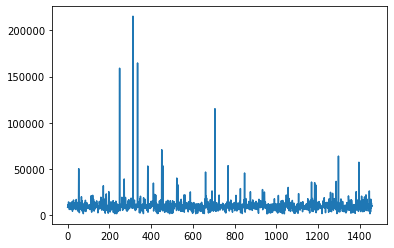

In [94]:
# viewing distibution of LotArea
sns.set_style(rc={'figure.figsize':(10,8)})
train.LotArea.plot()

In [95]:
# #deleating columns with only one value
def checking_unique_value(data):
    for col in data.columns:
            if len(data[col].unique()) == 1:
                data=data.drop(col,axis=1)
    return data
train=checking_unique_value(train)
test=checking_unique_value(test)


<AxesSubplot:xlabel='YearBuilt', ylabel='Count'>

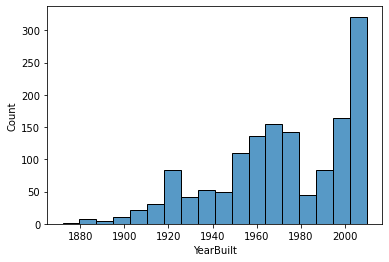

In [96]:
# viewing distibution of YearBuilt
sns.histplot(data=train,x='YearBuilt')

In [97]:
# split our train sample to X_train , y_train and processing right_answers 
X_train=train.drop(['SalePrice'],axis=1)
y_train = train.SalePrice
right_answers=right_answers.drop(['Id'],axis=1)
right_answers=right_answers.to_numpy()
right_answers=right_answers.reshape(-1,1)

In [98]:
# deleting highly correlated columns
columns_to_delete=[]
cor_matrix = X_train.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop_train = list([column for column in upper_tri.columns if any(upper_tri[column] > 0.6)])
cor_matrix = test.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop_test= list([column for column in upper_tri.columns if any(upper_tri[column] > 0.6)])
for column_to_delete in to_drop_test:
    if column_to_delete in to_drop_train:
        columns_to_delete.append(column_to_delete)
test=test.drop(columns_to_delete,axis=1)
X_train=X_train.drop(columns_to_delete,axis=1)


In [99]:
# one hot encoding  
columns_to_encode_train=list(X_train.select_dtypes(include='object').columns)
columns_to_encode_test=list(test.select_dtypes(include='object').columns)
X_train=pd.get_dummies(data=X_train,columns=columns_to_encode_train)
test=pd.get_dummies(data=test,columns=columns_to_encode_test)

Now we must to choose the best model to our task.We will compare DecisionTreeRegressor , LinearRegression and .

In [100]:
# choosing parametrs for DecisionTreeRegressor and RandomForestRegressor
parameters={'max_depth':range(1,51,10),'min_samples_leaf':range(1,51,5),'min_samples_split':range(2,101,5)}

In [101]:
#Checking score of DecisionTreeRegressor 
tree=DecisionTreeRegressor(random_state=42)
random_regressor=RandomizedSearchCV(tree,parameters,cv=5)
random_regressor.fit(X_train,y_train)
tree=random_regressor.best_estimator_
tree.score(X_train,y_train)

0.8529741283476936

In [102]:
#Checking score of LinearRegression
model=LinearRegression()
model.fit(X_train,y_train)
model.score(X_train,y_train)

0.9104091304852584

In [103]:
#Checking score  of RandomForestRegressor
forest = RandomForestRegressor()
random_regressor=RandomizedSearchCV(forest,parameters,cv=5)
random_regressor.fit(X_train,y_train)
forest=random_regressor.best_estimator_

In [104]:
#predicting and processing  data
predict_tree=tree.predict(test)
predict_model=model.predict(test)
predict_tree = np.reshape(predict_tree, (1459, 1))
predict_model = np.reshape(predict_model, (1459, 1))
predict_forest=forest.predict(test)


In [105]:
# saving score 
score_tree=mean_squared_error(right_answers,predict_tree)
score_forest=mean_squared_error(right_answers,predict_forest)
score_model=mean_squared_error(right_answers,predict_model)